In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
    calc_sharpe,
    calc_double_sharpe,
    calc_max_dd,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [2]:
provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'univ2_pair',
            'ignore_min_timestamp': True,
        }
    },
    {
        'provider': 'bigquery',
        'options': {
            'table': 'univ2_hour',
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df_pair = dfs[0]
    df_hour = dfs[1]
    
    weth_id = '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'

    df_pair.loc[df_pair['token0_id'] == weth_id, 'eth_is_0'] = True
    df_pair.loc[df_pair['token1_id'] == weth_id, 'eth_is_0'] = False
    df_pair = df_pair.dropna()

    df_hour = df_hour.merge(df_pair[['id', 'eth_is_0', 'token0_symbol', 'token1_symbol']], left_on='pair_id', right_on='id')
    df_hour = df_hour.dropna()
    idx = df_hour['eth_is_0'] == True
    df_hour.loc[idx, 'price'] = df_hour.loc[idx, 'reserve0'] / df_hour.loc[idx, 'reserve1']
    df_hour.loc[~idx, 'price'] = df_hour.loc[~idx, 'reserve1'] / df_hour.loc[~idx, 'reserve0']
    df_hour.loc[idx, 'vwap'] = df_hour.loc[idx, 'hourlyVolumeToken0'] / df_hour.loc[idx, 'hourlyVolumeToken1']
    df_hour.loc[~idx, 'vwap'] = df_hour.loc[~idx, 'hourlyVolumeToken1'] / df_hour.loc[~idx, 'hourlyVolumeToken0']
    df_hour.loc[idx, 'eth_reserve'] = df_hour.loc[idx, 'reserve0']
    df_hour.loc[~idx, 'eth_reserve'] = df_hour.loc[~idx, 'reserve1']
    df_hour.loc[idx, 'eth_volume'] = df_hour.loc[idx, 'hourlyVolumeToken0']
    df_hour.loc[~idx, 'eth_volume'] = df_hour.loc[~idx, 'hourlyVolumeToken1']
    df_hour.loc[idx, 'symbol_text'] = df_hour.loc[idx, 'token1_symbol']
    df_hour.loc[~idx, 'symbol_text'] = df_hour.loc[~idx, 'token0_symbol']
    
    df_hour = df_hour.rename(columns={
        'pair_id': 'symbol',
        'hourlyTxns': 'trades',
    })
    # df_hour['symbol'] = df_hour['symbol'].astype('category') # this leads to slow groupby
    
    df_hour = df_hour[['timestamp', 'symbol', 'symbol_text', 'price', 'eth_reserve', 'eth_volume', 'vwap', 'trades']]
    
    df = df_hour.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)
df = df.dropna()
df.to_pickle('/tmp/df_univ2.pkl')
display(df)

,id,timestamp,token0_id,token0_symbol,token1_id,token1_symbol
0,0xa78710b1fdaf3114e8e064159d07365b64aee3fc,2020-07-05 01:54:17+00:00,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,0xea52d0d5659d6c897068c8eb9bdeeb1fe1d44cf6,CS
1,0x68d691e70921af8e076c34dddb04f2a0a5564dba,2020-06-12 18:44:04+00:00,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,0xc663f73138fd8fe3d313e0ce37bdfa0a89bca330,DD
2,0xee7564231458b4866b8a36987767a552abe1f558,2020-07-06 01:39:23+00:00,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,0xf19d1fa22dfc1e9b416df265305e41dfabb79d89,MU
3,0x37d36d0583dfd611794559054ed19c009aa9cbf4,2020-07-04 15:18:06+00:00,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,0xd066421c8700fbfaf988130d88ea4f9c15c9178f,TT
4,0xbaf8763e544771ff10ae68ba3821e2b35f1bd817,2020-07-07 08:43:28+00:00,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,0xd9467327499e51609dc0493f0e5d6cbcc7d3fe01,UN
...,...,...,...,...,...,...
110909,0x829547f75bd12b96bd2338d09dc5baeac94095e2,2021-07-23 12:09:17+00:00,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,0xd19cc0257507b9d1bbdef3a763eaf0c6672826ee,FLOKI-FINAL-TEST
110910,0x36bb7c43421eebe6dc86cb1756e9fd888ef15ddf,2021-07-17 20:57:43+00:00,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,0xe74db777210198ed1474dfe05ed683d91476b29a,RocketMoney 🚀
110911,0x4a947f0ea53cb9d05a683bf3f1f700464b4b9913,2021-07-30 17:01:01+00:00,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,0xe18f13991461aae5672b0ce7943f6805374780f5,CryptoRocket 🚀
110912,0x076ea808b9f4614bd7f18784c6acfcb7974fe4c6,2021-07-08 07:41:49+00:00,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,0xccacdf46e412717608054494c15a8a3e6b8a69fb,YOOOO🔥🔥🔥


,timestamp,pair_id,reserve0,reserve1,reserveUSD,hourlyVolumeToken0,hourlyVolumeToken1,hourlyVolumeUSD,hourlyTxns
0,2021-09-14 09:00:00+00:00,0xf043c39a106db6b58c76995f30ba35fd211c3b76,4.719691e+06,796.033805,5.309656e+06,655.715000,0.110912,369.898216,1.0
1,2021-09-14 12:00:00+00:00,0xf043c39a106db6b58c76995f30ba35fd211c3b76,4.724277e+06,795.733686,5.321613e+06,443.981633,0.075000,250.788055,1.0
2,2021-09-13 12:00:00+00:00,0xf043c39a106db6b58c76995f30ba35fd211c3b76,4.738105e+06,792.715967,5.144642e+06,2478.125000,0.413579,1342.041772,1.0
3,2021-09-23 00:00:00+00:00,0xf043c39a106db6b58c76995f30ba35fd211c3b76,3.941176e+06,960.146106,5.884502e+06,39068.917665,9.584395,29370.211693,1.0
4,2021-09-05 20:00:00+00:00,0xf043c39a106db6b58c76995f30ba35fd211c3b76,4.944807e+06,748.172459,5.882134e+06,306.001782,0.046436,182.539745,1.0
...,...,...,...,...,...,...,...,...,...
11047596,2021-03-27 08:00:00+00:00,0xf91c12dae1313d0be5d7a27aa559b1171cc1eac5,2.702906e+04,1349.829752,4.559119e+06,0.999717,0.050074,84.564059,2.0
11047597,2021-03-30 10:00:00+00:00,0xf91c12dae1313d0be5d7a27aa559b1171cc1eac5,3.580747e+04,1954.068567,7.162991e+06,84.626950,4.621166,8471.096799,2.0
11047598,2021-03-29 14:00:00+00:00,0xf91c12dae1313d0be5d7a27aa559b1171cc1eac5,3.486318e+04,1865.264314,6.640856e+06,197.243555,10.533572,18747.128872,2.0
11047599,2021-03-22 12:00:00+00:00,0xf9fdd3a82566cbaf5dd3d3094d8dd9aaa72a1c36,7.608781e+06,245.304042,8.782309e+05,29982.513867,0.967534,1732.980932,2.0


symbol_text  \
timestamp                 symbol                                                   
2020-05-05 21:00:00+00:00 0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc        USDC   
2020-05-06 16:00:00+00:00 0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc        USDC   
2020-05-06 18:00:00+00:00 0x12ede161c702d1494612d19f05992f43aa6a26fb        CHAI   
                          0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc        USDC   
2020-05-11 02:00:00+00:00 0x12ede161c702d1494612d19f05992f43aa6a26fb        CHAI   
...                                                                          ...   
2022-11-16 14:00:00+00:00 0xff06393c6c42409a73ae0e5d4e2e2e9b4016c814         WCP   
                          0xff46d5837f9b7ae71fcc32b4e28ec96d2e39c826      dynBTC   
                          0xff58711683be66dad6e0e20e0043af46fc7f5f49         CHZ   
                          0xff85d3c00a35328aca1525c996f6ef3c5cac4882       SDOGE   
                          0xffa98a091331df4600f87c9164cd27e8a5cd2405        POLS   

                                                                         price  \
timestamp                 symbol                                                 
2020-05-05 21:00:00+00:00 0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc  0.004963   
2020-05-06 16:00:00+00:00 0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc  0.004973   
2020-05-06 18:00:00+00:00 0x12ede161c702d1494612d19f05992f43aa6a26fb  0.004857   
                          0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc  0.004966   
2020-05-11 02:00:00+00:00 0x12ede161c702d1494612d19f05992f43aa6a26fb  0.004780   
...                                                                        ...   
2022-11-16 14:00:00+00:00 0xff06393c6c42409a73ae0e5d4e2e2e9b4016c814  0.000002   
                          0xff46d5837f9b7ae71fcc32b4e28ec96d2e39c826  0.000958   
                          0xff58711683be66dad6e0e20e0043af46fc7f5f49  0.000182   
                          0xff85d3c00a35328aca1525c996f6ef3c5cac4882  0.000002   
                          0xffa98a091331df4600f87c9164cd27e8a5cd2405  0.000269   

                                                                      eth_reserve  \
timestamp                 symbol                                                    
2020-05-05 21:00:00+00:00 0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc     0.004909   
2020-05-06 16:00:00+00:00 0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc     0.004914   
2020-05-06 18:00:00+00:00 0x12ede161c702d1494612d19f05992f43aa6a26fb     0.005506   
                          0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc     0.004910   
2020-05-11 02:00:00+00:00 0x12ede161c702d1494612d19f05992f43aa6a26fb     0.028858   
...                                                                           ...   
2022-11-16 14:00:00+00:00 0xff06393c6c42409a73ae0e5d4e2e2e9b4016c814    32.252678   
                          0xff46d5837f9b7ae71fcc32b4e28ec96d2e39c826    20.455130   
                          0xff58711683be66dad6e0e20e0043af46fc7f5f49    36.153358   
                          0xff85d3c00a35328aca1525c996f6ef3c5cac4882     2.075981   
                          0xffa98a091331df4600f87c9164cd27e8a5cd2405   658.039023   

                                                                        eth_volume  \
timestamp                 symbol                                                     
2020-05-05 21:00:00+00:00 0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc  5.415458e-05   
2020-05-06 16:00:00+00:00 0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc  4.983090e-06   
2020-05-06 18:00:00+00:00 0x12ede161c702d1494612d19f05992f43aa6a26fb  6.804365e-06   
                          0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc  3.412398e-06   
2020-05-11 02:00:00+00:00 0x12ede161c702d1494612d19f05992f43aa6a26fb  4.794286e-08   
...                                                                            ...   
2022-11-16 14:00:00+00:00 0xff06393c6c42409a73ae0e5d4e2e2e9b4016c814  9.099285e+00   
                          0xf

In [3]:
from joblib import Parallel, delayed

def calc_features(df):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df)

def do_calc_features(df):
    dfs = []
    df = df.sort_values(['symbol', 'timestamp']).reset_index().copy() # needed for performance?
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(delayed(calc_features_single)(df_symbol))
        # dfs.append(calc_features_single(df_symbol))
    dfs = Parallel(n_jobs=-1)(dfs)
    df = pd.concat(dfs).set_index(['timestamp', 'symbol']).sort_index()
    return df

def calc_features_single(df):
    df = df.copy()
    
    # df['ret'] = (df['price'].shift(-24 * 7 - 1) / df['price'].shift(-1) - 1).fillna(0)
    df['eth_reserve_entry'] = df['eth_reserve'].shift(-1).fillna(0)
    df['eth_reserve_exit'] = df['eth_reserve'].shift(-25).fillna(0)
    for i in [6, 12, 24, 48, 96]:
        df['feature_cl_diff_{}'.format(i)] = (df['price'] / df['price'].shift(i) - 1).fillna(0)
        df['feature_eth_reserve_diff_{}'.format(i)] = (df['eth_reserve'] / df['eth_reserve'].shift(i) - 1).fillna(0)
        # df['feature_volume_{}'.format(i)] = (df['eth_volume'] / (1e-37 + df['eth_volume'].rolling(i, 1).sum())).fillna(0) # not good
        df['feature_cl_rsi_{}'.format(i)] = signed_rsi_sma(df['price'])
        df['feature_vwap_rsi_{}'.format(i)] = signed_rsi_sma(df['vwap'])
        df['feature_eth_reserve_rsi_{}'.format(i)] = signed_rsi_sma(df['eth_reserve'])
    
    df = df.loc[df['eth_reserve'] > 100]
    # df = df.loc[df['eth_reserve'] > 1000]
    
    return df

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean()).fillna(0)

In [49]:
df = pd.read_pickle('/tmp/df_univ2.pkl')
df = calc_features(df)
df['ret'] = df.groupby('symbol')['price'].transform(lambda x: x.shift(-24 - 1) / x.shift(-1) - 1).fillna(0)
display(df)

/tmp/ipykernel_43462/422480163.py:5: UserWarning: Persisting input arguments took 20.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return mem.cache(do_calc_features)(df)


symbol_text  \
timestamp                 symbol                                                   
2020-05-18 18:00:00+00:00 0x55d5c232d921b9eaa6b37b5845e439acd04b4dba         HEX   
                          0xc5a788f63e5d9cf2c324621eed51a98f85ae373b        DZAR   
2020-05-18 19:00:00+00:00 0x55d5c232d921b9eaa6b37b5845e439acd04b4dba         HEX   
                          0xc5a788f63e5d9cf2c324621eed51a98f85ae373b        DZAR   
2020-05-18 20:00:00+00:00 0x55d5c232d921b9eaa6b37b5845e439acd04b4dba         HEX   
...                                                                          ...   
2022-10-22 19:00:00+00:00 0xf7d31825946e7fd99ef07212d34b9dad84c396b7        BONE   
                          0xfcad5c316f5618a79852f89e1a9b18103e48a456        ZINU   
                          0xfcdae85317be9d0239cf11f99f3b7980925ee089         EGT   
                          0xff578ac8ef9df9d02368842b7b0810a14e770d71         ROO   
                          0xffa98a091331df4600f87c9164cd27e8a5cd2405        POLS   

                                                                             price  \
timestamp                 symbol                                                     
2020-05-18 18:00:00+00:00 0x55d5c232d921b9eaa6b37b5845e439acd04b4dba  2.099030e-05   
                          0xc5a788f63e5d9cf2c324621eed51a98f85ae373b  2.469416e-04   
2020-05-18 19:00:00+00:00 0x55d5c232d921b9eaa6b37b5845e439acd04b4dba  2.121150e-05   
                          0xc5a788f63e5d9cf2c324621eed51a98f85ae373b  2.462807e-04   
2020-05-18 20:00:00+00:00 0x55d5c232d921b9eaa6b37b5845e439acd04b4dba  2.084131e-05   
...                                                                            ...   
2022-10-22 19:00:00+00:00 0xf7d31825946e7fd99ef07212d34b9dad84c396b7  7.147911e-04   
                          0xfcad5c316f5618a79852f89e1a9b18103e48a456  1.119911e-11   
                          0xfcdae85317be9d0239cf11f99f3b7980925ee089  4.466752e-07   
                          0xff578ac8ef9df9d02368842b7b0810a14e770d71  1.906246e-10   
                          0xffa98a091331df4600f87c9164cd27e8a5cd2405  3.279498e-04   

                                                                      eth_reserve  \
timestamp                 symbol                                                    
2020-05-18 18:00:00+00:00 0x55d5c232d921b9eaa6b37b5845e439acd04b4dba   114.614932   
                          0xc5a788f63e5d9cf2c324621eed51a98f85ae373b   759.093148   
2020-05-18 19:00:00+00:00 0x55d5c232d921b9eaa6b37b5845e439acd04b4dba   121.435066   
                          0xc5a788f63e5d9cf2c324621eed51a98f85ae373b   742.384662   
2020-05-18 20:00:00+00:00 0x55d5c232d921b9eaa6b37b5845e439acd04b4dba   128.103226   
...                                                                           ...   
2022-10-22 19:00:00+00:00 0xf7d31825946e7fd99ef07212d34b9dad84c396b7   107.683688   
                          0xfcad5c316f5618a79852f89e1a9b18103e48a456   251.662175   
                          0xfcdae85317be9d0239cf11f99f3b7980925ee089   159.902960   
                          0xff578ac8ef9df9d02368842b7b0810a14e770d71   228.785847   
                          0xffa98a091331df4600f87c9164cd27e8a5cd2405   726.572676   

                                                                      eth_volume  \
timestamp                 symbol                                                   
2020-05-18 18:00:00+00:00 0x55d5c232d921b9eaa6b37b5845e439acd04b4dba   30.744149   
                          0xc5a788f63e5d9cf2c324621eed51a98f85ae373b    3.901084   
2020-05-18 19:00:00+00:00 0x55d5c232d921b9eaa6b37b5845e439acd04b4dba   15.061306   
                          0xc5a788f63e5d9cf2c324621eed51a98f85ae373b    0.993989   
2020-05-18 20:00:00+00:00 0x55d5c232d921b9eaa6b37b5845e439acd04b4dba   77.679760   
...                                                                          ...   
2022-10-22 19:00:00+00:00 0xf7d31825946e7fd99ef07212d34b9dad84c396b7    0.61119

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,price,eth_reserve,eth_volume,vwap,trades,ret,eth_reserve_entry,eth_reserve_exit,feature_cl_diff_6,feature_eth_reserve_diff_6,...,vwap_per_price,volume_per_reserve,symbol_len,symbol_first,symbol_second,symbol_third,symbol_fourth,symbol_last,symbol_usd,symbol_lower
price,1.000000,0.369646,0.245160,0.965200,0.116399,0.000613,-0.000153,-0.006630,-0.007748,-0.010229,...,0.106104,0.030798,0.127653,NaN,NaN,-0.019373,0.177783,NaN,NaN,0.052321
eth_reserve,0.369646,1.000000,0.512035,0.372332,0.368567,0.023845,0.023351,0.066412,-0.047694,-0.042483,...,0.139884,0.088452,-0.053809,NaN,NaN,0.006847,-0.059053,NaN,NaN,-0.018134
eth_volume,0.245160,0.512035,1.000000,0.203231,0.881429,0.003312,0.005829,0.026468,0.061428,0.048028,...,0.122419,0.862282,-0.060364,NaN,NaN,-0.000128,-0.076092,NaN,NaN,-0.120889
vwap,0.965200,0.372332,0.203231,1.000000,0.076282,0.008337,0.007949,0.001783,-0.014069,-0.014255,...,0.112241,-0.004458,0.104907,NaN,NaN,-0.006343,0.185181,NaN,NaN,0.038779
trades,0.116399,0.368567,0.881429,0.076282,1.000000,-0.016580,0.005614,0.019735,0.086402,0.079239,...,0.065633,0.817494,-0.054865,NaN,NaN,0.000783,-0.084316,NaN,NaN,-0.138580
ret,0.000613,0.023845,0.003312,0.008337,-0.016580,1.000000,-0.019900,-0.002964,0.004254,-0.036658,...,0.001516,-0.012928,-0.007813,NaN,NaN,0.000831,0.006515,NaN,NaN,0.003955
eth_reserve_entry,-0.000153,0.023351,0.005829,0.007949,0.005614,-0.019900,1.000000,0.371463,-0.089459,-0.009678,...,-0.003382,-0.006017,0.000068,NaN,NaN,0.108230,0.003174,NaN,NaN,0.004316
eth_reserve_exit,-0.006630,0.066412,0.026468,0.001783,0.019735,-0.002964,0.371463,1.000000,-0.130782,-0.027045,...,-0.006090,-0.004356,-0.005239,NaN,NaN,0.080044,-0.004397,NaN,NaN,0.010435
feature_cl_diff_6,-0.007748,-0.047694,0.061428,-0.014069,0.086402,0.004254,-0.089459,-0.130782,1.000000,0.317238,...,-0.021573,0.120387,-0.002701,NaN,NaN,0.000222,-0.013349,NaN,NaN,-0.013320
feature_eth_reserve_diff_6,-0.010229,-0.042483,0.048028,-0.014255,0.079239,-0.036658,-0.009678,-0.027045,0.317238,1.000000,...,0.007712,0.093762,0.008310,NaN,NaN,0.000220,0.001870,NaN,NaN,0.005176


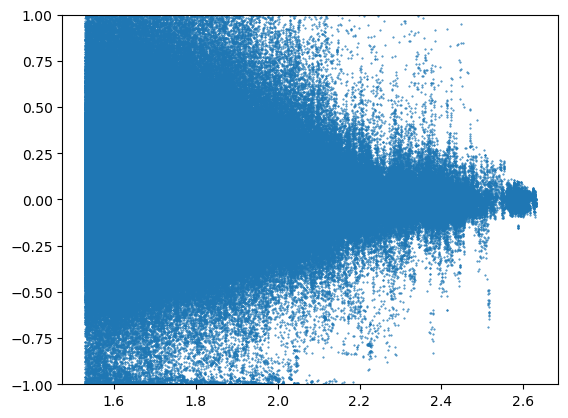

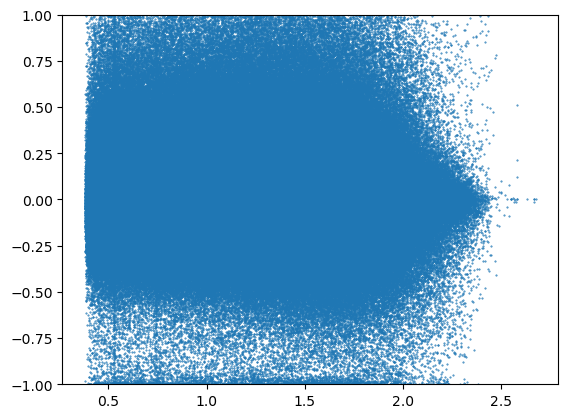

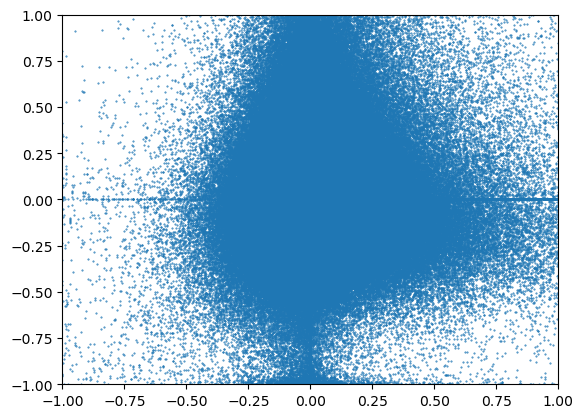

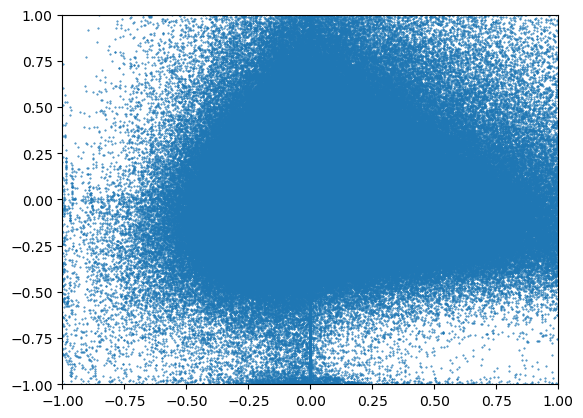

,imp
feature_cl_diff_96,857.031171
feature_cl_diff_12,721.308143
feature_cl_diff_24,683.039041
feature_eth_reserve_diff_96,676.254849
feature_eth_reserve_diff_48,540.241738
feature_cl_diff_48,508.614705
feature_cl_diff_6,476.282305
feature_eth_reserve_diff_24,402.718891
feature_eth_reserve_diff_12,358.060401
feature_eth_reserve_diff_6,276.284046


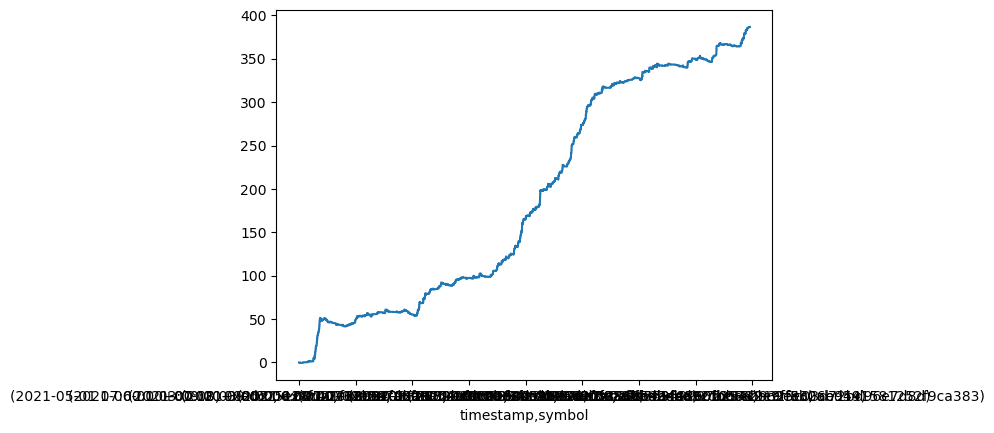

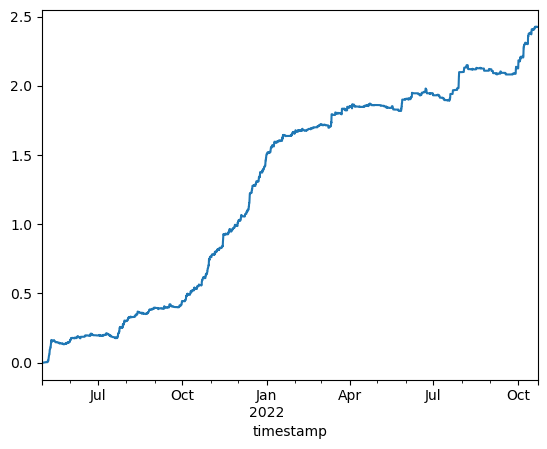

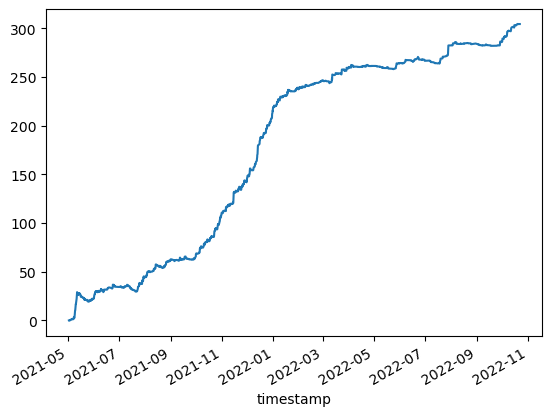

PearsonRResult(statistic=0.08138603550710377, pvalue=0.0)
0.12528980487765182
345.3548692937044
354.3181379490901


In [60]:
def func1(df):
    def safe_ord(x):
        return -1 if len(x) == 0 else ord(x)
    
    df['price'] = np.log(df['price'])
    df['vwap_per_price'] = np.log(df['vwap'] / df['price'])
    df['eth_reserve'] = np.log1p(df['eth_reserve'])
    df['eth_volume'] = np.log1p(df['eth_volume'])
    df['volume_per_reserve'] = df['eth_volume'] / df['eth_reserve']
    df['trades'] = np.log1p(df['trades'])
    df['symbol_len'] = df['symbol_text'].str.len() * 1.0
    df['symbol_first'] = df['symbol_text'].str[:1].apply(safe_ord) * 1.0
    df['symbol_second'] = df['symbol_text'].str[1:2].apply(safe_ord) * 1.0
    df['symbol_third'] = df['symbol_text'].str[2:3].apply(safe_ord) * 1.0
    df['symbol_fourth'] = df['symbol_text'].str[3:4].apply(safe_ord) * 1.0
    df['symbol_last'] = df['symbol_text'].str[-1:].apply(safe_ord) * 1.0
    df['symbol_usd'] = df['symbol_text'].str.contains('USD') * 1.0
    df['symbol_lower'] = df['symbol_text'].str.contains('[a-z]') * 1.0
    
    df = df.loc[df['volume_per_reserve'] > 0.1]
    # df = df.loc[df['trades'] > np.log1p(10)]
    
    display(df.dropna().select_dtypes(include=['float64']).clip(-10, 10).corr())

    plt.scatter(np.log(df['eth_reserve']), df['ret'], s=0.2)
    plt.ylim(-1, 1)
    plt.show()

    plt.scatter(np.log1p(df['eth_volume']), df['ret'], s=0.2)
    plt.ylim(-1, 1)
    plt.show()

    plt.scatter(df['feature_cl_diff_6'], df['ret'], s=0.2)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()

    plt.scatter(df['feature_cl_diff_24'], df['ret'], s=0.2)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()
    
    model = lgb.LGBMRegressor(
        # n_estimators=1000,
        # learning_rate=0.01,
        extra_trees=True,
        random_state=1,
        n_jobs=-1,
        importance_type="gain",
    )
    features = get_feature_columns(df)
    # features = [x for x in df.columns if x not in ['ret', 'symbol_text', 'eth_reserve_entry', 'eth_reserve_exit']]

    test_min_idx = int(df.shape[0] * 0.5)
    model.fit(df[features].iloc[:test_min_idx], df['ret'].iloc[:test_min_idx].clip(-1, 1))
    # model.fit(df[features].iloc[:test_min_idx], np.log1p(df['ret']).iloc[:test_min_idx].clip(-1, 1))
    # model.fit(df[features].iloc[:test_min_idx], (df['ret'].iloc[:test_min_idx] > 0.1) * 1.0)

    importance = pd.DataFrame(model.feature_importances_, index=features, columns=['imp'])
    display(importance.sort_values('imp', ascending=False))
    
    y_pred = model.predict(df[features].iloc[test_min_idx:])
    df_y_pred = pd.Series(y_pred, index=df.index[test_min_idx:])
    y_pred = y_pred * (df_y_pred.groupby('timestamp').transform('max') == df_y_pred).values
    trade_idx = y_pred > 0.05
    
    (trade_idx * df['ret'].iloc[test_min_idx:].clip(-1, 1)).cumsum().plot()
    plt.show()
    (trade_idx * df['ret'].iloc[test_min_idx:].clip(-1, 1)).groupby('timestamp').mean().cumsum().plot()
    plt.show()
    df['ret'].iloc[test_min_idx:].loc[trade_idx].clip(-1, 1).groupby('timestamp').mean().cumsum().plot()
    plt.show()
    
    print(pearsonr(df['ret'].iloc[test_min_idx:].clip(-1, 1), y_pred))
    print(df['ret'].iloc[test_min_idx:].loc[trade_idx].clip(-1, 1).mean())
    print(df['eth_reserve_entry'].iloc[test_min_idx:].loc[trade_idx].mean())
    print(df['eth_reserve_exit'].iloc[test_min_idx:].loc[trade_idx].mean())
    
func1(df.copy())

In [4]:
def visualize_result(df, execution_cost=0.001, horizon=None):
    df = df.copy()

    # calc return
    df["ret_pos"] = df["ret"] * df["position"]
    if horizon is None:
        # old logic
        df["hour"] = df.index.get_level_values("timestamp").hour
        df["position_prev"] = df.groupby(["hour", "symbol"])["position"].shift(1).fillna(0)
    else:
        df["position_prev"] = df.groupby(["symbol"])["position"].shift(horizon).fillna(0)
    df["cost"] = (df["position"] - df["position_prev"]).abs() * execution_cost
    df["ret_pos_cost"] = df["ret_pos"] - df["cost"]

    # print statistics
    for with_cost in [False, True]:
        if with_cost:
            print("return with cost statistics")
            x = df.groupby("timestamp")["ret_pos_cost"].sum()
        else:
            print("return without cost statistics")
            x = df.groupby("timestamp")["ret_pos"].sum()

        print("mean {}".format(np.mean(x)))
        print("std {}".format(np.std(x)))
        print("sharpe {}".format(calc_sharpe(x)))
        print("double sharpe {}".format(calc_double_sharpe(x, 24 * 30)))
        print("max drawdown {}".format(calc_max_dd(x.cumsum())))
        print("min {}".format(np.min(x)))
        print("min sharpe {}".format(-np.mean(x) / np.min(x)))

    # plot total ret
    df.groupby("timestamp")["ret_pos"].sum().cumsum().plot(label="ret without cost")
    df.groupby("timestamp")["ret_pos_cost"].sum().cumsum().plot(label="ret with cost")
    df.groupby("timestamp")["cost"].sum().cumsum().plot(label="cost")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("total return")
    plt.show()

In [5]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self):
        self._model = Ridge(fit_intercept=False, alpha=1e5)
        self._model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            random_state=1,
            n_jobs=-1,
        )
        # self._model = BaggingRegressor(self._model, random_state=1)
        
        self._model = Pipeline([
            # ('remove_nonstationary1', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     remove_ratio=0.1,
            # )),
            # ('remove_nonstationary2', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     remove_ratio=0.1,
            # )),
            # ('zca', ZcaTransformer(intensity=0.1)), # good?
            # ('zca', ZcaTransformer(intensity=1.0)),
            ('model', self._model)
        ])
        
        self.max_data_sec = 7 * 24 * 60 * 60 # for predict script
        self.provider_configs = provider_configs
        self.merge_data = merge_data

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret']) - 0.5
        df = df.dropna()
        
        print('fit df.shape', df.shape)
        
        self._model.fit(df[features], df['ret'])
    
    def predict(self, df):
        df_orig = df.copy()
        df = self._calc_features(df)
        
        features = get_feature_columns(df)
        df['y_pred'] = self._model.predict(df[features])
        
        # max_amount = 1.0
        max_amount = 10.0
        df['opt_amount'], df['opt_ret_cost'] = calc_optimum_amount(df['y_pred'], df['eth_reserve'], max_amount)
        
        df['position'] = 0.0
        df.loc[df.groupby('timestamp')['opt_ret_cost'].idxmax(), 'position'] = 1.0
        
        print(df.loc[df['position'] > 0, 'opt_amount'].mean())
        print(df.loc[df['position'] > 0, 'eth_reserve'].mean())
        
        df_orig['position'] = 0.0
        df_orig.loc[df.index, 'position'] = df['position']
        return df_orig['position']
    
    def _calc_features(self, df):        
        df = calc_features(df)
            
        for col in get_feature_columns(df):
            df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5

        return df
    

def calc_optimum_amount(ret, reserve, max_amount):
    fee = 0.003
    gas = 0.01
    # amount = (ret - fee) * reserve / 2
    # amount = np.minimum(amount, max_amount)
    # am = np.where(amount <= 0, 0, amount)
    # ret_cost = np.where(amount <= 0, 0, (ret - (amount / reserve + fee + gas / amount)) * amount)
    
    amount = (gas * reserve) ** 0.5
    amount = np.minimum(amount, max_amount)
    am = np.where(amount <= 0, 0, amount)
    ret_cost = np.where(amount <= 0, 0, ret - 2 * (amount / reserve + fee + gas / amount))
    
    return am, ret_cost

/tmp/ipykernel_85956/3776253667.py:5: UserWarning: Persisting input arguments took 21.25s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return mem.cache(do_calc_features)(df)


fit df.shape (4737642, 35)


/tmp/ipykernel_85956/3776253667.py:5: UserWarning: Persisting input arguments took 5.69s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return mem.cache(do_calc_features)(df)


3.340164007973556
4259.5169284624035


/tmp/ipykernel_85956/3776253667.py:5: UserWarning: Persisting input arguments took 20.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return mem.cache(do_calc_features)(df)


fit df.shape (3603237, 35)


/tmp/ipykernel_85956/3776253667.py:5: UserWarning: Persisting input arguments took 12.81s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return mem.cache(do_calc_features)(df)


2.797402868335035
3258.14715306161


/tmp/ipykernel_85956/3776253667.py:5: UserWarning: Persisting input arguments took 21.74s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return mem.cache(do_calc_features)(df)


fit df.shape (4069347, 35)


/tmp/ipykernel_85956/3776253667.py:5: UserWarning: Persisting input arguments took 10.02s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return mem.cache(do_calc_features)(df)


2.3814335539647367
1048.2083544471989


/tmp/ipykernel_85956/3776253667.py:5: UserWarning: Persisting input arguments took 19.61s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return mem.cache(do_calc_features)(df)


fit df.shape (4507361, 35)


/tmp/ipykernel_85956/3776253667.py:5: UserWarning: Persisting input arguments took 7.67s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return mem.cache(do_calc_features)(df)


2.083062015839247
770.7137811154901


/tmp/ipykernel_85956/3776253667.py:5: UserWarning: Persisting input arguments took 20.21s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return mem.cache(do_calc_features)(df)


fit df.shape (4867313, 35)


/tmp/ipykernel_85956/3776253667.py:5: UserWarning: Persisting input arguments took 7.36s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return mem.cache(do_calc_features)(df)


2.1747766153756536
812.5196115262378
return without cost statistics
mean 0.10871609772168009
std 0.3604789951686855
sharpe 0.30158788494959765
double sharpe 1.309442584062299
max drawdown 30.959165707919084
min -1.0
min sharpe 0.10871609772168009
return with cost statistics
mean 0.10713553646227328
std 0.36057063908013176
sharpe 0.2971277326839247
double sharpe 1.281092147660001
max drawdown 31.814165707918733
min -1.0027130666783273
min sharpe 0.10684565707035172


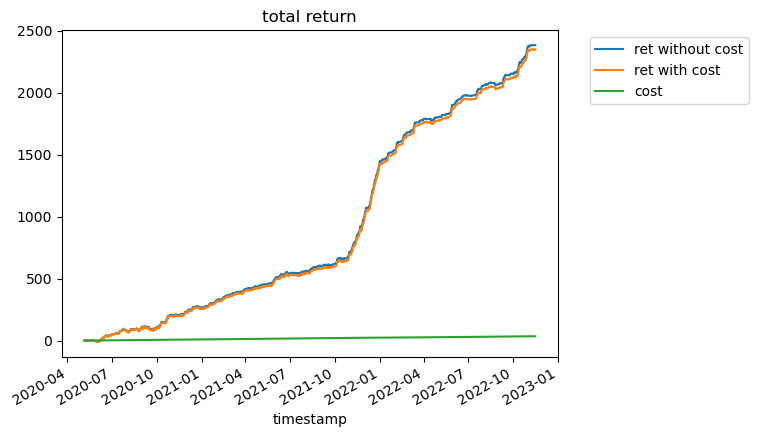

/tmp/ipykernel_85956/3776253667.py:5: UserWarning: Persisting input arguments took 24.13s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return mem.cache(do_calc_features)(df)


fit df.shape (5461238, 35)


In [6]:
df = pd.read_pickle('/tmp/df_univ2.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-16 00:00:00Z')]
# df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2022-09-01 00:00:00Z')]
df['ret'] = df.groupby('symbol')['price'].transform(lambda x: x.shift(-24 - 1) / x.shift(-1) - 1).fillna(0).clip(-1, 1)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank()

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
# visualize_result(df_cv.dropna(), horizon=12)
# visualize_result(df_cv.dropna(), horizon=4)

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20221116_uniswap.xz', 'wb') as f:
    f.write(data)

2.4678670241572886
1854.3151716010402
timestamp                  symbol                                    
2022-11-09 14:00:00+00:00  0x00030110a7053083a7a160449a0e8f1adce9438d    0.0
                           0x006ab11e89e7246cb8c0f7bdaa8c2713374b1676    0.0
                           0x01962144d41415cca072900fe87bbe2992a99f10    0.0
                           0x02d9ea26c35b584dd4393c984d1611003be38984    0.0
                           0x0529bf56c9448eafe144c151402bc11c0ff47c4c    0.0
                                                                        ... 
2022-11-16 14:00:00+00:00  0xff06393c6c42409a73ae0e5d4e2e2e9b4016c814    0.0
                           0xff46d5837f9b7ae71fcc32b4e28ec96d2e39c826    0.0
                           0xff58711683be66dad6e0e20e0043af46fc7f5f49    0.0
                           0xff85d3c00a35328aca1525c996f6ef3c5cac4882    0.0
                           0xffa98a091331df4600f87c9164cd27e8a5cd2405    0.0
Name: position, Length: 82719, dtype: float64

position1  \
timestamp                 symbol                                                  
2022-11-09 15:00:00+00:00 0x006ab11e89e7246cb8c0f7bdaa8c2713374b1676        0.0   
                          0x045d41d14de5488d11c831c5dbbbc45462e2a1b0        0.0   
                          0x049b4493010fc0ee3deed6a7fcae4e5fba86bb45        0.0   
                          0x04b6be23297548d828c3c4e4b7fb3f4a67d2dae3        0.0   
                          0x0529bf56c9448eafe144c151402bc11c0ff47c4c        0.0   
...                                                                         ...   
2022-11-16 13:00:00+00:00 0xfcc88d59f7b470e84a73ed092fe674eee5d83b19        0.0   
                          0xfcdae85317be9d0239cf11f99f3b7980925ee089        0.0   
                          0xff58711683be66dad6e0e20e0043af46fc7f5f49        0.0   
                          0xff734dcb7fd6517caed5c6c8720992a0c676c800        0.0   
                          0xffa98a091331df4600f87c9164cd27e8a5cd2405        0.0   

                                                                      position2  \
timestamp                 symbol                                                  
2022-11-09 15:00:00+00:00 0x006ab11e89e7246cb8c0f7bdaa8c2713374b1676        0.0   
                          0x045d41d14de5488d11c831c5dbbbc45462e2a1b0        0.0   
                          0x049b4493010fc0ee3deed6a7fcae4e5fba86bb45        0.0   
                          0x04b6be23297548d828c3c4e4b7fb3f4a67d2dae3        0.0   
                          0x0529bf56c9448eafe144c151402bc11c0ff47c4c        0.0   
...                                                                         ...   
2022-11-16 13:00:00+00:00 0xfcc88d59f7b470e84a73ed092fe674eee5d83b19        0.0   
                          0xfcdae85317be9d0239cf11f99f3b7980925ee089        0.0   
                          0xff58711683be66dad6e0e20e0043af46fc7f5f49        0.0   
                          0xff734dcb7fd6517caed5c6c8720992a0c676c800        0.0   
                          0xffa98a091331df4600f87c9164cd27e8a5cd2405        0.0   

                                                                      position3  
timestamp                 symbol                                                 
2022-11-09 15:00:00+00:00 0x006ab11e89e7246cb8c0f7bdaa8c2713374b1676        0.0  
                          0x045d41d14de5488d11c831c5dbbbc45462e2a1b0        0.0  
                          0x049b4493010fc0ee3deed6a7fcae4e5fba86bb45        0.0  
                          0x04b6be23297548d828c3c4e4b7fb3f4a67d2dae3        0.0  
                          0x0529bf56c9448eafe144c151402bc11c0ff47c4c        0.0  
...                                                                         ...  
2022-11-16 13:00:00+00:00 0xfcc88d59f7b470e84a73ed092fe674eee5d83b19        0.0  
                          0xfcdae85317be9d0239cf11f99f3b7980925ee089        0.0  
                          0xff58711683be66dad6e0e20e0043af46fc7f5f49        0.0  
                          0xff734dcb7fd6517caed5c6c8720992a0c676c800        0.0  
                          0xffa98a091331df4600f87c9164cd27e8a5cd2405        0.0  

[81648 rows x 3 columns]

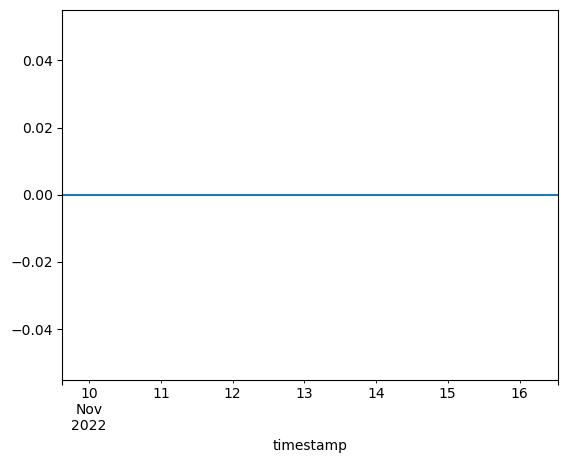

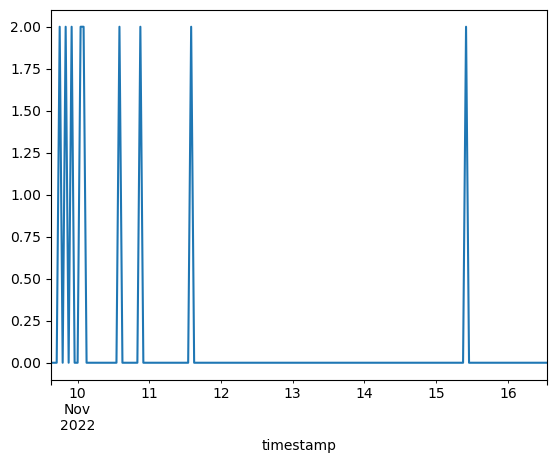

In [1]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20221116_uniswap.xz')
df = pd.read_pickle('/tmp/df_univ2.pkl')
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
# print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

df_test['pos2_err'] = (df_test['position2'] - df_test['position1']).abs() 
df_test['pos3_err'] = (df_test['position3'] - df_test['position1']).abs() 

df_test.groupby('timestamp')['pos2_err'].sum().plot()
plt.show()
df_test.groupby('timestamp')['pos3_err'].sum().plot()
plt.show()

# for symbol, df_symbol in df_test.groupby('symbol'):
#     df_symbol = df_symbol.reset_index().set_index('timestamp')
#     (df_symbol['position2'] - df_symbol['position1']).plot()
# plt.show()

# for symbol, df_symbol in df_test.groupby('symbol'):
#     df_symbol = df_symbol.reset_index().set_index('timestamp')
#     print(symbol, df_symbol.shape)
#     (df_symbol['position3'] - df_symbol['position1']).plot()
# plt.show()